<a href="https://colab.research.google.com/github/joel-winterton/Contagion/blob/main/Within%20patch%20model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model
Within-patch model from [1] is an aged structured SIR/SEIR like model, that uses an infectious profile to give model a latent stage. Let there be $n$ age groups, then for the $i$th age group:
$$ S_i(t+1) = S_i(t)e^{-\lambda_i(t)}$$
$$ I_i(t) = S_i(t)(1-e^{-\lambda_i(t)})$$
where $S_i(t)$ is the number of susceptible individuals in age group $i$ at time $t$ and $I_i(t)$ is the number of new infections at time $t$.
The force of infection is:
$$\lambda_i(t) = \sum_{\tau = 1}^{\tau_{\text{max}}}R_0\beta(\tau) \sum_j A_{ij} I_{j}(t-\tau)$$ and
$$ \hat{A}_{ij} = B_{ij}\frac{n_j}{n_i}$$
$$ A_{ij} = \frac{\hat A_{ij}}{\rho(\hat A)}$$
1. Klepac, P., Kissler, S., Gog, J., 2018. Contagion! The BBC Four Pandemic – The model behind the documentary. Epidemics 24, 49–59. https://doi.org/10.1016/j.epidem.2018.03.003

# Data
For this model we need the matrix $B_{ij}$ which is the average number of individuals a person in group $j$ will contact in group $i$. We will also need census data for $n_j$, the number of people in group $j$. For now we declare dummy data.

# Import libraries

In [139]:
import numpy as np
import matplotlib.pyplot as plt

# Load data

In [140]:
B = np.array([
    [5 , 3],
    [2.2 , 3.9]])
group_sizes = np.array([100, 150])

number_of_groups = len(group_sizes)

beta = np.array([0., 0., 1.6, 0.8, 0.2, 0.2]) # day 0,1,2,3,4,5
R_nought = 1.8
tau_max = len(beta) - 1

number_of_days = 100


# Create force of infection

In [141]:
def make_transition_rate_fn(infectious_profile, reproductive_number, contact_matrix):
  """
  Precalculates parameters and returns function to calculate transition rates.
  """
  # Calculate A from contact matrix
  # multiply jth column by jth population and divide ith row by ith population using diagonal matrices
  A_hat = np.matmul(np.diag(1/group_sizes),np.matmul(contact_matrix , np.diag(group_sizes)))
  # Divide through by maximum eigenvalue
  A = A_hat/np.linalg.eigh(A_hat)[0][-1]

  infectious_profile_matrix = np.broadcast_to(infectious_profile[1:]/infectious_profile.sum(), (number_of_groups, len(infectious_profile)-1))
  def transition_rate_fn(t, state):
    """
    Calculates the transition rate for each group at time t in days given the state before t.
    Returns array where ith element is ith force of infection.
    """
    index = t + 5
    S,I = state
    infections = np.array(I[:,index-tau_max:index])
    transition_values = infectious_profile_matrix*np.matmul(A, infections)
    return reproductive_number*transition_values.sum(axis=1)

  return transition_rate_fn

# Start stepping

In [142]:
def simulate():
  # first five entries are before t=0
  I = np.array([[0.002, 0.002, 0.002, 0.002, 0.002, 0.00]+[-1.]*number_of_days]*number_of_groups)
  S = np.array([[0., 0., 0., 0., 0., 0.99]+[-1.]*number_of_days]*number_of_groups)
  trans_fn = make_transition_rate_fn(beta, R_nought, B)

  for t in range(number_of_days):
    index = t+5
    forces_of_infection = trans_fn(t, (S,I))
    probability_of_infection = 1 - np.exp(-forces_of_infection)
    S[:,index+1] = S[:,index]*(1-probability_of_infection)
    I[:,index+1] = S[:,index]*probability_of_infection
  return S,I

# Have a look

In [143]:
S,I = simulate()
time = np.linspace(0, number_of_days-1, number_of_days)

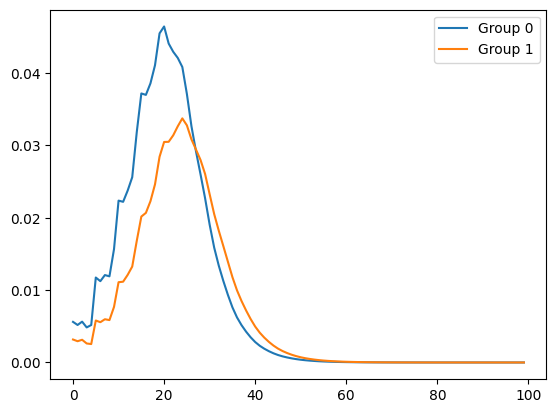

In [144]:
for i in range(number_of_groups):
  plt.plot(time, I[i,6:], label=f"Group {i}")
plt.legend()
plt.show()

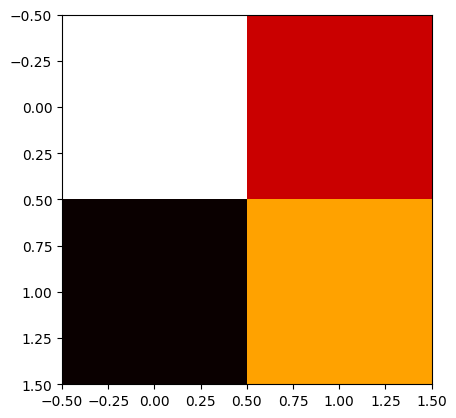

In [145]:
plt.imshow(B, cmap='hot', interpolation='nearest')
plt.show()